In [2]:
# 03_confidence_analysis.ipynb
# Part 3: Confidence Calibration & Reliability

# Imports and Setup
from utils import *

setup_plotting_style()
print_section_header("PART 3: CONFIDENCE ANALYSIS")

# Load Data
df_models, df_class_stats, df_confusion = load_all_data()


PART 3: CONFIDENCE ANALYSIS


In [ ]:
# Calculate Confidence Metrics
print_subsection_header("1. CONFIDENCE METRICS")

df_models['Overconfidence_Rate'] = calculate_overconfidence_rate(df_models)
df_models['Risk_Score'] = calculate_risk_score(df_models)

print("\nConfidence Summary:")
print(df_models[['Model', 'Avg_Confidence_Correct', 'Avg_Confidence_Incorrect', 
                 'Confidence_Gap', 'High_Confidence_Errors']].to_string(index=False))



--------------------------------------------------------------------------------
1. CONFIDENCE METRICS
--------------------------------------------------------------------------------

Confidence Summary:
           Model  Avg_Confidence_Correct  Avg_Confidence_Incorrect  Confidence_Gap  High_Confidence_Errors
           LeNet                0.987305                  0.751953        0.235352                     132
       SimpleCNN                0.996094                  0.777832        0.218262                      27
         AlexNet                0.965820                  0.694824        0.270996                     165
        ResNet18                0.998047                  0.812500        0.185547                      38
        ResNet34                0.997559                  0.823730        0.173828                      47
        ResNet50                0.997559                  0.818848        0.178711                      36
     MobileNetV2                0.995605     

In [ ]:
# Model Calibration Ranking
print_subsection_header("2. CALIBRATION RANKING")

df_sorted = df_models.sort_values('Confidence_Gap', ascending=False)

print("\nBEST CALIBRATED MODELS:")
print(df_sorted[['Model', 'Confidence_Gap', 'Avg_Confidence_Correct']].head(5).to_string(index=False))

print("\nWORST CALIBRATED MODELS:")
print(df_sorted[['Model', 'Confidence_Gap', 'Avg_Confidence_Correct']].tail(5).to_string(index=False))



--------------------------------------------------------------------------------
2. CALIBRATION RANKING
--------------------------------------------------------------------------------

BEST CALIBRATED MODELS:
       Model  Confidence_Gap  Avg_Confidence_Correct
     AlexNet        0.270996                0.965820
       LeNet        0.235352                0.987305
   SimpleCNN        0.218262                0.996094
 InceptionV3        0.214355                0.997559
ShuffleNetV2        0.194824                0.998047

WORST CALIBRATED MODELS:
           Model  Confidence_Gap  Avg_Confidence_Correct
        ResNet50        0.178711                0.997559
  EfficientNetB0        0.174316                0.998047
        ResNet34        0.173828                0.997559
MobileNetV3Small        0.164062                0.998535
     DenseNet121        0.154297                0.998535


In [ ]:
# Overconfidence & Risk Analysis
print_subsection_header("3. OVERCONFIDENCE & RISK")

df_risk = df_models.sort_values('Risk_Score', ascending=False)

print("\nMOST DANGEROUS MODELS:")
print(df_risk[['Model', 'Risk_Score', 'High_Confidence_Errors', 
               'Overconfidence_Rate']].head(5).to_string(index=False))

print("\nSAFEST MODELS:")
print(df_risk[['Model', 'Risk_Score', 'High_Confidence_Errors']].tail(5).to_string(index=False))



--------------------------------------------------------------------------------
3. OVERCONFIDENCE & RISK
--------------------------------------------------------------------------------

MOST DANGEROUS MODELS:
           Model  Risk_Score  High_Confidence_Errors  Overconfidence_Rate
         AlexNet  114.645996                     165            33.742331
           LeNet   99.257812                     132            44.147157
     MobileNetV2   41.691406                      52            55.319149
        ResNet34   38.715332                      47            61.842105
MobileNetV3Small   37.551270                      45            65.217391

SAFEST MODELS:
       Model  Risk_Score  High_Confidence_Errors
    ResNet50   29.478516                      36
 DenseNet121   24.482910                      29
ShuffleNetV2   22.490234                      28
   SimpleCNN   21.001465                      27
 InceptionV3   17.230469                      22


In [ ]:
# Correlation Analysis
print_subsection_header("4. CORRELATION ANALYSIS")

print_correlation('Confidence_Gap', 'Final_Accuracy', df_models)
print_correlation('High_Confidence_Errors', 'Final_Accuracy', df_models)



--------------------------------------------------------------------------------
4. CORRELATION ANALYSIS
--------------------------------------------------------------------------------
Correlation: Confidence_Gap <-> Final_Accuracy: -0.8164 (p=0.0012)
Correlation: High_Confidence_Errors <-> Final_Accuracy: -0.9840 (p=0.0000)


(np.float64(-0.9839905873599152), np.float64(8.063138035302715e-09))

In [ ]:
# Categorize Models
print_subsection_header("5. MODEL CATEGORIZATION")

high_conf_gap_threshold = df_models['Confidence_Gap'].median()
high_overconf_threshold = df_models['Overconfidence_Rate'].median()

df_models['Category'] = df_models.apply(
    lambda row: categorize_model_by_confidence(
        row, high_conf_gap_threshold, high_overconf_threshold
    ), axis=1
)

print("\nMODEL CATEGORIES:")
print(df_models['Category'].value_counts())

for category in df_models['Category'].unique():
    print(f"\n{category}:")
    models_in_cat = df_models[df_models['Category'] == category][
        ['Model', 'Confidence_Gap', 'Overconfidence_Rate']
    ]
    print(models_in_cat.to_string(index=False))



--------------------------------------------------------------------------------
5. MODEL CATEGORIZATION
--------------------------------------------------------------------------------

MODEL CATEGORIES:
Category
Well-Calibrated & Safe           6
Poorly-Calibrated & Dangerous    6
Name: count, dtype: int64

Well-Calibrated & Safe:
       Model  Confidence_Gap  Overconfidence_Rate
       LeNet        0.235352            44.147157
   SimpleCNN        0.218262            48.214286
     AlexNet        0.270996            33.742331
 MobileNetV2        0.193848            55.319149
ShuffleNetV2        0.194824            56.000000
 InceptionV3        0.214355            50.000000

Poorly-Calibrated & Dangerous:
           Model  Confidence_Gap  Overconfidence_Rate
        ResNet18        0.185547            59.375000
        ResNet34        0.173828            61.842105
        ResNet50        0.178711            60.000000
MobileNetV3Small        0.164062            65.217391
  EfficientN

In [ ]:
#  Deployment Score
print_subsection_header("6. DEPLOYMENT RECOMMENDATIONS")

df_models['Deployment_Score'] = (
    df_models['Final_Accuracy'] + 
    (df_models['Confidence_Gap'] * 100) - 
    df_models['Overconfidence_Rate'] - 
    (df_models['High_Confidence_Errors'] / df_models['Total_Samples'] * 100)
)

deployment_ranking = df_models.sort_values('Deployment_Score', ascending=False)

print("\nTOP 5 FOR MEDICAL DEPLOYMENT:")
print(deployment_ranking[['Model', 'Deployment_Score', 'Final_Accuracy', 
                          'Category']].head(5).to_string(index=False))



--------------------------------------------------------------------------------
6. DEPLOYMENT RECOMMENDATIONS
--------------------------------------------------------------------------------

TOP 5 FOR MEDICAL DEPLOYMENT:
       Model  Deployment_Score  Final_Accuracy               Category
     AlexNet         87.335733       95.497652 Well-Calibrated & Safe
       LeNet         75.419672       97.247031 Well-Calibrated & Safe
   SimpleCNN         72.847684       99.484394 Well-Calibrated & Safe
 InceptionV3         70.827868       99.594881 Well-Calibrated & Safe
ShuffleNetV2         62.764256       99.539637 Well-Calibrated & Safe



--------------------------------------------------------------------------------
7. CREATING VISUALIZATIONS
--------------------------------------------------------------------------------
Saved figure: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\photos\step3_confidence_analysis.png


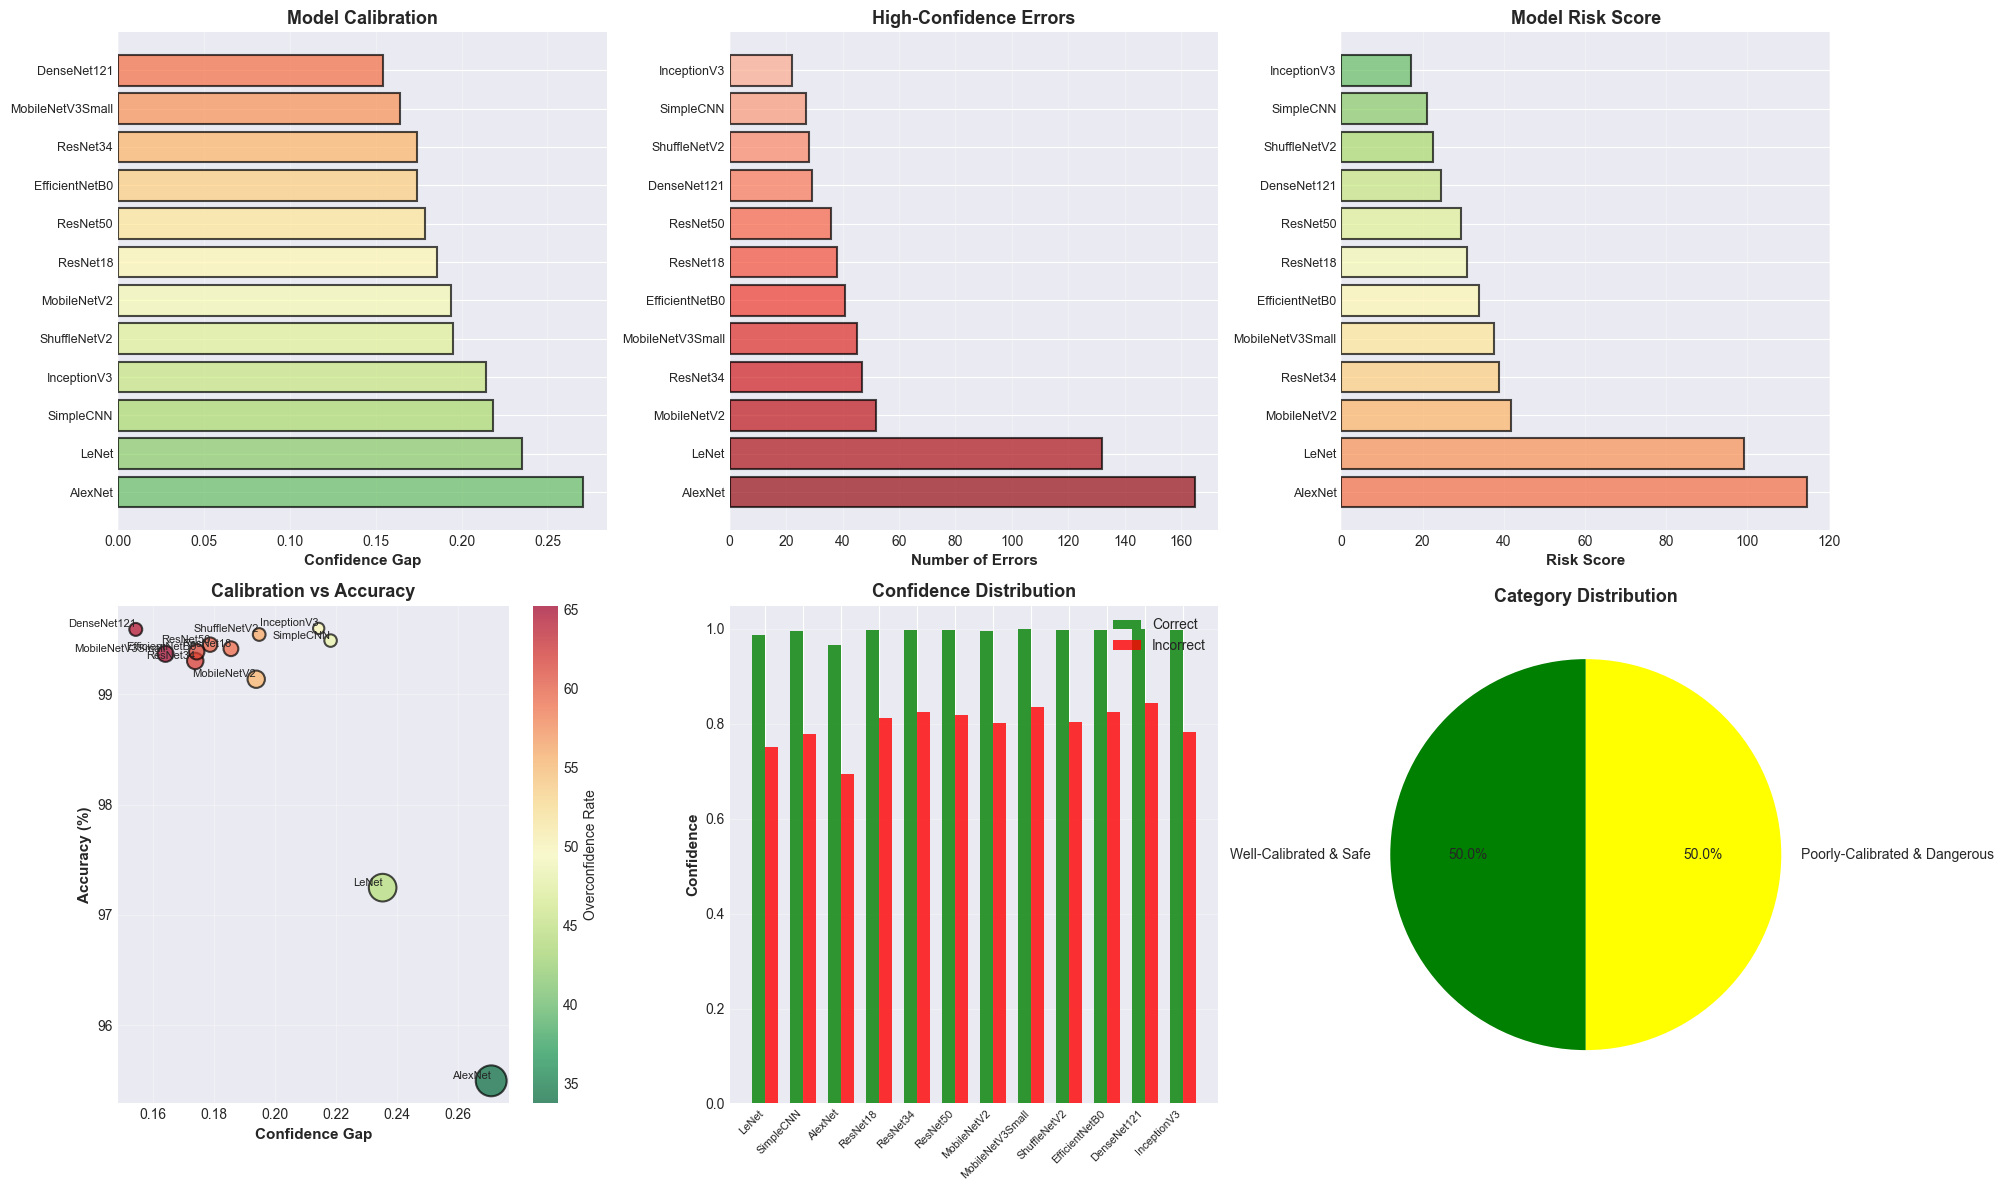

In [ ]:
# Create Visualizations
print_subsection_header("7. CREATING VISUALIZATIONS")

fig = plt.figure(figsize=(20, 12))

# Plot 1: Confidence Gap
ax1 = plt.subplot(2, 3, 1)
models_sorted = df_models.sort_values('Confidence_Gap', ascending=True)
colors_gap = plt.cm.RdYlGn(np.linspace(0.2, 0.8, len(models_sorted)))
create_horizontal_bar(ax1, models_sorted['Confidence_Gap'].values,
                     models_sorted['Model'].values,
                     'Model Calibration',
                     'Confidence Gap', colors_gap)

# Plot 2: High Confidence Errors
ax2 = plt.subplot(2, 3, 2)
models_sorted_hce = df_models.sort_values('High_Confidence_Errors', ascending=True)
colors_hce = plt.cm.Reds(np.linspace(0.3, 0.9, len(models_sorted_hce)))
create_horizontal_bar(ax2, models_sorted_hce['High_Confidence_Errors'].values,
                     models_sorted_hce['Model'].values,
                     'High-Confidence Errors',
                     'Number of Errors', colors_hce)

# Plot 3: Risk Score
ax3 = plt.subplot(2, 3, 3)
risk_sorted = df_models.sort_values('Risk_Score', ascending=True)
colors_risk = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(risk_sorted)))
create_horizontal_bar(ax3, risk_sorted['Risk_Score'].values,
                     risk_sorted['Model'].values,
                     'Model Risk Score',
                     'Risk Score', colors_risk)

# Plot 4: Confidence Gap vs Accuracy
ax4 = plt.subplot(2, 3, 4)
scatter1 = ax4.scatter(df_models['Confidence_Gap'], df_models['Final_Accuracy'],
                       s=df_models['High_Confidence_Errors']*3, 
                       c=df_models['Overconfidence_Rate'], cmap='RdYlGn_r', 
                       alpha=0.7, edgecolors='black', linewidth=1.5)
for i, model in enumerate(df_models['Model']):
    ax4.annotate(model, (df_models['Confidence_Gap'].iloc[i], 
                         df_models['Final_Accuracy'].iloc[i]),
                fontsize=8, ha='right', va='bottom')
ax4.set_xlabel('Confidence Gap', fontsize=11, fontweight='bold')
ax4.set_ylabel('Accuracy (%)', fontsize=11, fontweight='bold')
ax4.set_title('Calibration vs Accuracy', fontsize=13, fontweight='bold')
ax4.grid(True, alpha=0.3)
plt.colorbar(scatter1, ax=ax4, label='Overconfidence Rate')

# Plot 5: Confidence Distribution
ax5 = plt.subplot(2, 3, 5)
x_pos = np.arange(len(df_models))
width = 0.35
ax5.bar(x_pos - width/2, df_models['Avg_Confidence_Correct'], width, 
        label='Correct', alpha=0.8, color='green')
ax5.bar(x_pos + width/2, df_models['Avg_Confidence_Incorrect'], width, 
        label='Incorrect', alpha=0.8, color='red')
ax5.set_xticks(x_pos)
ax5.set_xticklabels(df_models['Model'], rotation=45, ha='right', fontsize=8)
ax5.set_ylabel('Confidence', fontsize=11, fontweight='bold')
ax5.set_title('Confidence Distribution', fontsize=13, fontweight='bold')
ax5.legend()
ax5.grid(True, alpha=0.3, axis='y')

# Plot 6: Category Distribution
ax6 = plt.subplot(2, 3, 6)
category_data = df_models['Category'].value_counts()
colors_cat = ['green', 'yellow', 'orange', 'red']
ax6.pie(category_data.values, labels=category_data.index, 
        autopct='%1.1f%%', startangle=90, 
        colors=colors_cat[:len(category_data)])
ax6.set_title('Category Distribution', fontsize=13, fontweight='bold')

save_figure('step3_confidence_analysis.png')
plt.show()

In [ ]:

# Save Results
print_subsection_header("8. SAVING RESULTS")

save_csv(df_models[['Model', 'Final_Accuracy', 'Confidence_Gap', 'Overconfidence_Rate',
                    'Risk_Score', 'Deployment_Score', 'Category']], 
         'step3_confidence_summary.csv')

save_csv(deployment_ranking[['Model', 'Deployment_Score', 'Category']], 
         'step3_deployment_recommendations.csv')

# Summary
print_section_header("PART 3 COMPLETE!")

print(f"\nKEY FINDINGS:")
print(f"  - Best calibrated: {df_sorted.iloc[0]['Model']}")
print(f"    Confidence Gap: {df_sorted.iloc[0]['Confidence_Gap']:.4f}")
print(f"\n  - Most dangerous: {df_risk.iloc[0]['Model']}")
print(f"    Risk Score: {df_risk.iloc[0]['Risk_Score']:.2f}")
print(f"\n  - Top for deployment: {deployment_ranking.iloc[0]['Model']}")
print(f"    Category: {deployment_ranking.iloc[0]['Category']}")


--------------------------------------------------------------------------------
8. SAVING RESULTS
--------------------------------------------------------------------------------
Saved CSV: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\reports\step3_confidence_summary.csv
Saved CSV: F:\up_git\off_plant_di_err_analyze_daok\analyze_and_results\reports\step3_deployment_recommendations.csv

PART 3 COMPLETE!

KEY FINDINGS:
  - Best calibrated: AlexNet
    Confidence Gap: 0.2710

  - Most dangerous: AlexNet
    Risk Score: 114.65

  - Top for deployment: AlexNet
    Category: Well-Calibrated & Safe
